Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("./Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('./Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
print(data_dir_train, data_dir_test)

Skin cancer ISIC The International Skin Imaging Collaboration/Train Skin cancer ISIC The International Skin Imaging Collaboration/Test


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, image_size=(img_height, img_width), subset='training',seed=123, validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = keras.preprocessing.image_dataset_from_directory(data_dir_train, image_size=(img_height, img_width), subset='validation',seed=123, validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

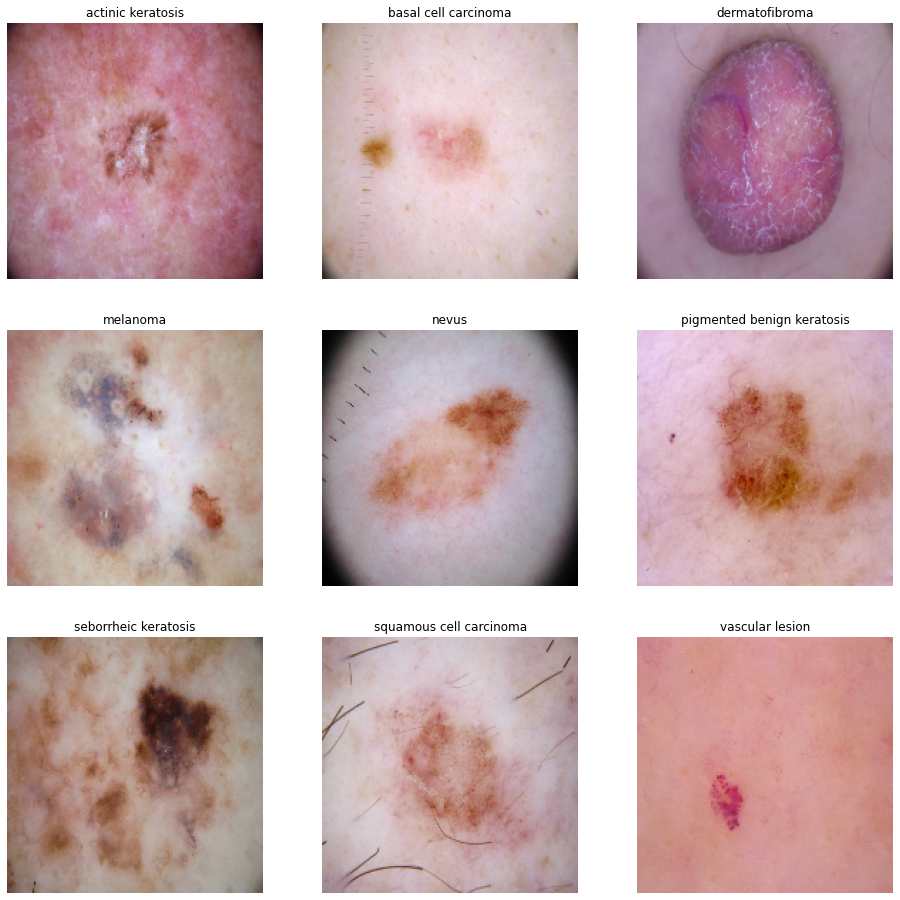

In [10]:
# setting figure size
plt.figure(figsize=(16, 16))
for i in range(len(class_names)):
    # filter the dataset for the classname 'i'
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    # take 1 batch from dataset and plot one image from the batch
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
# Create a layer for normalization of pizel values between [0,1] and required image dimensions
scaling_layer = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))

In [13]:
model = Sequential()
model.add(scaling_layer)
# Adding Convolition and Pooling layers
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D())
# Flattening the features
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(len(class_names)))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Choosing the 'adam' optimizer and categorical entropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(32,180,180,3))

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 84, 84, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 32)        0

### Train the model

In [16]:
# train the first model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 161ms/step - loss: 2.1481 - accuracy: 0.2182 - val_loss: 1.9231 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 7s 120ms/step - loss: 1.8418 - accuracy: 0.3315 - val_loss: 1.7159 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 7s 120ms/step - loss: 1.6200 - accuracy: 0.4012 - val_loss: 1.9273 - val_accuracy: 0.3311
Epoch 4/20
56/56 [==============================] - 7s 120ms/step - loss: 1.7060 - accuracy: 0.3744 - val_loss: 1.7386 - val_accuracy: 0.3758
Epoch 5/20
56/56 [==============================] - 7s 120ms/step - loss: 1.4240 - accuracy: 0.5028 - val_loss: 1.6773 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 7s 120ms/step - loss: 1.3116 - accuracy: 0.5374 - val_loss: 1.5543 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 7s 120ms/step - loss: 1.1565 - accuracy: 0.5904 - val_loss: 1.5704 - val_accuracy: 0.5145
Epoch

### Visualizing training results

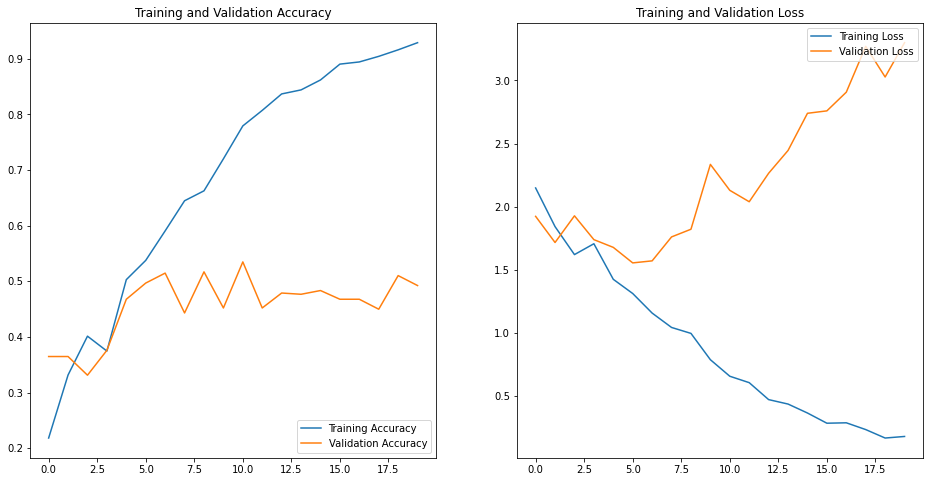

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

It can be seen that the training and validation accuracy, are far apart from each other after the first few iterations. This indicates that initially till model converged to some approximate weights and bias, the accuracies were similar. however as the model started converging, the training and validation accuracies started falling apart. The training accuracy lies in range of above 0.80 while that of validation accuracy lies in range of 0.5. 
Also, the losses incurred in both training and test data are very different. Infact validation loss is increasing gradually with epochs

**Inference**

From the curve above, it is clear that the model is overfitting.


*To combat the overfitting, the model should have more variance in the data. Hence, we can add some simple augemntation strategy first to confirm if this step would work. We will introduce simple mirroring and rotational changes into each image when training.*

In [18]:
# Creating new augmentation layer with rotation and flips/mirroring
data_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

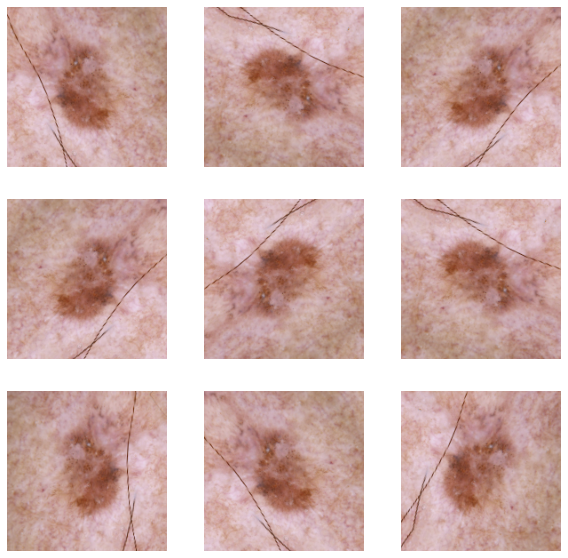

In [19]:
# Visualize how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model


In [20]:
# Create a layer for normalization of pizel values between [0,1] and required image dimensions
scaling_layer = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))

model = Sequential()
model.add(scaling_layer)
model.add(data_augmentation)
# Adding Convolition and Pooling layers
# model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
# model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D())
# Adding flattening layer
model.add(layers.Flatten())
# Add additional dense layer to bring down the parameter count to 1000 most important parameters
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(len(class_names)))

### Compiling the model

In [21]:
## Using 'adam' optimizer and 'categorical_crossentropy' for loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(32,180,180,3))
# View summary of the model to be trained
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 41, 41, 32)       

### Training the model

In [22]:
## Train model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 70ms/step - loss: 2.0968 - accuracy: 0.1836 - val_loss: 1.9580 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.8369 - accuracy: 0.3170 - val_loss: 1.7613 - val_accuracy: 0.3579
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6250 - accuracy: 0.4096 - val_loss: 1.5548 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4994 - accuracy: 0.4531 - val_loss: 1.7503 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.5405 - accuracy: 0.4542 - val_loss: 1.4455 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4656 - accuracy: 0.4810 - val_loss: 1.5736 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4602 - accuracy: 0.4688 - val_loss: 1.4061 - val_accuracy: 0.5168
Epoch 8/20
56

### Visualizing the results

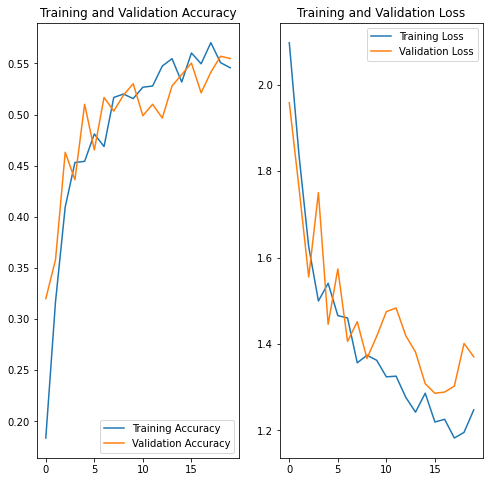

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

The above curves of accuracy and loss show that the training and validation accuracies lie in close range. Hence, the model is not overfitting. It is giving consistent results in both the datasets. The technique for data augmentation with flipping and rotating the images actually worked.

However, the model does seem to be underfitting since both the accuracies are lying in the range of 0.5-0.6. Thus we need to employ some strategy to combat this issue. 

*Since we are dealing with classification problem, let's find the distribution of classes in the training dataset. Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.*

In [24]:
# Construct a list of the path to every image in the Train dataset folder
path_list = glob(os.path.join(data_dir_train, '*','*.jpg'))
# Construct a list of the image class names using the folder names
lesion_list = [os.path.basename(os.path.dirname(y)) for y in path_list]

In [25]:
# Map path and corresponding class name of image
sample_class_dict = dict(zip(path_list, lesion_list))
# Construct a dataframe
original_df = pd.DataFrame({'Path': sample_class_dict.keys(), 'Label': sample_class_dict.values()})
original_df.head()

Path  Label
0  Skin cancer ISIC The International Skin Imagin...  nevus
1  Skin cancer ISIC The International Skin Imagin...  nevus
2  Skin cancer ISIC The International Skin Imagin...  nevus
3  Skin cancer ISIC The International Skin Imagin...  nevus
4  Skin cancer ISIC The International Skin Imagin...  nevus

In [26]:
original_df.Label.value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [27]:
original_df.Label.value_counts() / original_df.shape[0] * 100

pigmented benign keratosis    20.634212
melanoma                      19.562305
basal cell carcinoma          16.793211
nevus                         15.944618
squamous cell carcinoma        8.083966
vascular lesion                6.208129
actinic keratosis              5.091559
dermatofibroma                 4.242966
seborrheic keratosis           3.439035
Name: Label, dtype: float64

- `pigmented benign keratosis` has the maximum number of samples in dataset 
- `seborrheic keratosis` has the least number of samples in the dataset
- `pigmented benign keratosis `, `basal cell carcinoma`,  `melanoma `, `nevus` dominate the proportionate number of samples in dataset

Now that we have noticed the class imbalance is present in the dataset, we must rectify the class imbalance. To do that we will add some more samples of each class in the dataset.

We will use `Augmentor` package (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="{}/".format(str(data_dir_train))
if not os.path.isdir(os.path.join(data_dir_train, class_names[0],'output')):
    import Augmentor
    for i in class_names:
        p = Augmentor.Pipeline(path_to_training_dataset + i)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
else:
    print('Augmented images already exist')

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98BA0044F0>:   0%|          | 1/500 [00:00<01:36,  5.17 Samples/s]Initialised with 114 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98B975A9A0>: 100%|██████████| 500/500 [00:12<00:00, 38.99 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]Initialised with 376 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98B970B0A0>: 100%|██████████| 500/500 [00:11<00:00, 41.93 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]Initialised with 95 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F98B97C0D90>: 100%|██████████| 500/500 [00:12<00:00, 39.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]Initialised with 438 image(s) found.
Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F98B97096A0>: 100%|██████████| 500/500 [00:49<00:00, 10.05 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
# Construct a list of the path to every image in the Train dataset folder
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000396.jpg_39730b6f-5aed-4921-827e-17ab3f792c2a.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028314.jpg_8854295f-8ec8-4ce4-8135-e69e1050885c.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000383.jpg_9b906de8-01a5-496e-831c-9a577e7a2f00.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0028076.jpg_e8c14a77-1e19-47d2-858e-9c1c11a2c1ab.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output/nevus_original_ISIC_0000067.jpg_9c8478f6-dd35-4405-9643-0ea75e9dc29e.jpg']

In [32]:
# Construct a list of the image class names using the folder names
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['nevus', 'nevus', 'nevus', 'nevus', 'nevus']

In [33]:
# Map path and corresponding class name of image
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
# Construct a dataframe of new images sampled using Augmentor package
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Combine the original dataframe and new 
new_df = original_df.append(df2)

In [35]:
# Checking the new count of each image class sample
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [36]:
# Checking the new distribution of images 
new_df.Label.value_counts() / new_df.shape[0] * 100

pigmented benign keratosis    14.275115
melanoma                      13.918979
basal cell carcinoma          12.998961
nevus                         12.717020
squamous cell carcinoma       10.105357
vascular lesion                9.482119
actinic keratosis              9.111144
dermatofibroma                 8.829203
seborrheic keratosis           8.562101
Name: Label, dtype: float64

In [37]:
batch_size = 32
img_height = 180
img_width = 180

*Since the files have changed, we will need to reconstruct the Dataset from the directory*

#### Create a training dataset

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model

In [40]:
# Create a layer for normalization of pizel values between [0,1] and required image dimensions
scaling_layer = layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height, img_width, 3))

model = Sequential()
model.add(scaling_layer)
# model.add(data_augmentation)   We will remove augmentation layer since we have already augmented each image using Augmentor library and stored in the training dir

# Adding Convolition and Pooling layers
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(filters=32, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling2D())
# Adding a dropout layer to prevent overfitting
model.add(layers.Dropout(0.25))
# Add flattening layer
model.add(layers.Flatten())
# Add a dense layer to bring down the number of parameters to 500
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(len(class_names)))


#### Compile the model

In [41]:
## Using 'adam' optimizer and 'categorical_crossentropy' for loss
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.build(input_shape=(32,180,180,3))
# View summary of the model to be trained
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 87, 87, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 39, 39, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)       

####  Train the model

In [42]:
epochs = 30
# Training model for 30 epochs
history = model.fit(train_ds, validation_data = val_ds,
    epochs=epochs,
)

Epoch 1/30
169/169 [==============================] - 25s 138ms/step - loss: 1.8921 - accuracy: 0.2789 - val_loss: 1.6432 - val_accuracy: 0.3534
Epoch 2/30
169/169 [==============================] - 24s 136ms/step - loss: 1.5226 - accuracy: 0.4154 - val_loss: 1.4472 - val_accuracy: 0.4321
Epoch 3/30
169/169 [==============================] - 23s 135ms/step - loss: 1.3980 - accuracy: 0.4590 - val_loss: 1.4464 - val_accuracy: 0.4655
Epoch 4/30
169/169 [==============================] - 23s 136ms/step - loss: 1.3099 - accuracy: 0.5087 - val_loss: 1.2763 - val_accuracy: 0.5330
Epoch 5/30
169/169 [==============================] - 23s 135ms/step - loss: 1.1742 - accuracy: 0.5551 - val_loss: 1.1838 - val_accuracy: 0.5598
Epoch 6/30
169/169 [==============================] - 23s 135ms/step - loss: 1.0904 - accuracy: 0.5918 - val_loss: 1.1135 - val_accuracy: 0.5694
Epoch 7/30
169/169 [==============================] - 23s 134ms/step - loss: 1.0060 - accuracy: 0.6328 - val_loss: 0.9647 - val_ac

#### Visualize the model results

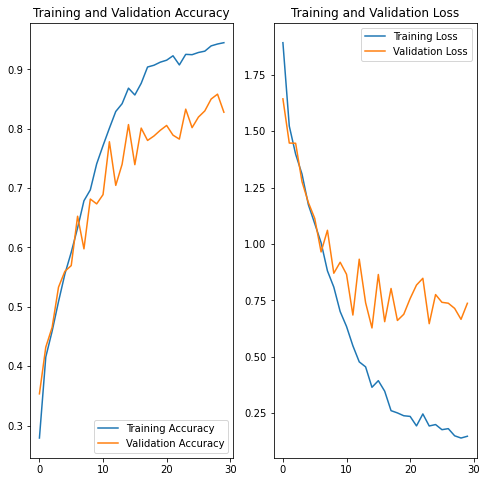

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Observations**

From the above curves, it can be seen that the augmentation of data with new images using Augmentor library indeed helped us tackle the issue of overfitting and underfitting. Class imbalance is a very common issue and even in a small dataset like this one, it can create a huge difference in terms of model accuracy. The model now is more robust and is able to acheive accuracies of 0.93 and 0.84 in training and validation dataset respectively. 
<br/>


## Summary
Although the accuracies are good reaching a peak of 0.95 for training and 0.86 for validation, there is room for improvement. But the issue lies due to the lack of data. Due to that, the algorithm tends to overfit. And in order to mitigate the overfitting issue, we are using regularization using Dropouts which reduces both training and validation accuracies.
We can gather more data and run the same algorithm which will then result in *much lower losses* and hence better gain in accuracy